# Wavelength-Dependent Sensor Effects

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import os.path

In [3]:
import astropy.table

In [4]:
import scipy.interpolate
import scipy.integrate

In [5]:
band_color = dict(u='magenta', g='blue', r='green', i='gold', z='orange', y='red')

## LSST Optical Properties

Read LSST throughput contributions from a local checkout of the [lsst/throughputs](https://github.com/lsst/throughputs) package into the same directory as this notebook, e.g.
```
git clone https://github.com/lsst/throughputs.git
```
See [here](https://confluence.lsstcorp.org/display/SIM/Throughput+models+in+the+Catalogs+Simulation+Framework) for details of the package contents.

u-band eff. wavelength = 367.070 nm
g-band eff. wavelength = 482.685 nm
r-band eff. wavelength = 622.324 nm
i-band eff. wavelength = 754.598 nm
z-band eff. wavelength = 869.090 nm
y-band eff. wavelength = 971.028 nm


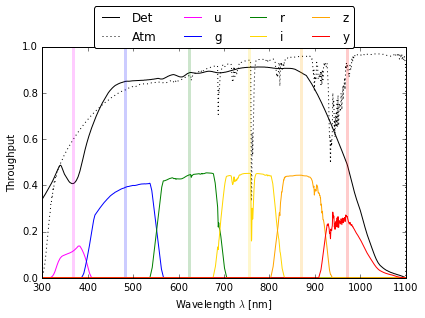

In [6]:
def load_lsst_optical_properties(save=None):
    
    out = astropy.table.Table(meta=dict(description='LSST Throughputs'))
    
    det = astropy.table.Table.read('throughputs/baseline/detector.dat',
                                   format='ascii', names=('wlen', 'thru'))
    plt.plot(det['wlen'], det['thru'], 'k-', label='Det')
    out['wlen'] = astropy.table.Column(det['wlen'], unit='nm', description='Wavelength')
    out['det'] = astropy.table.Column(det['thru'], description='Detector throughput')
    
    atm = astropy.table.Table.read('throughputs/baseline/atmos_std.dat',
                                   format='ascii', names=('wlen', 'thru'))
    plt.plot(atm['wlen'], atm['thru'], 'k:', label='Atm')
    assert np.array_equal(det['wlen'], atm['wlen'])
    out['atm'] = astropy.table.Column(atm['thru'], description='Detector throughput')
    
    for band in 'ugrizy':
        total = astropy.table.Table.read('throughputs/baseline/total_{0}.dat'.format(band),
                                         format='ascii', names=('wlen', 'thru'))
        plt.plot(total['wlen'], total['thru'], color=band_color[band], label='{0}'.format(band))
        assert np.array_equal(det['wlen'], total['wlen'])
        out[band] = astropy.table.Column(
            total['thru'], description='Total {0}-band throughput'.format(band))
        # Calculate the effective wavelength.
        eff_wlen = np.sum(out['wlen'] * out[band]) / np.sum(out[band])
        print '{0}-band eff. wavelength = {1:.3f} nm'.format(band, eff_wlen)
        plt.axvline(eff_wlen, ls='-', lw=3, alpha=0.2, color=band_color[band])

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
               ncol=4, fancybox=True)
    plt.xlabel('Wavelength $\lambda$ [nm]')
    plt.ylabel('Throughput')
    plt.xlim(300., 1100.)
    plt.ylim(0., 1.)
    plt.tight_layout()
    if save:
        plt.savefig(save)
        
    return out

lsst = load_lsst_optical_properties()

## Silicon Optical Properties

Read tabulated data from this paper linked [here](https://www2.pvlighthouse.com.au/Resources/Photovoltaic%20materials/Refractive%20index/Refractive%20index.aspx):

C. Schinke, P.C Peest, J. Schmidt, R. Brendel, K. Bothe, M.R Vogt, I. Kröger, S. Winter, A. Schirmacher, S. Lim, et al.,'Uncertainty analysis for the coefficient of band-to-band absorption of crystalline silicon', AIP Advances 5, p. 067168, 2015.

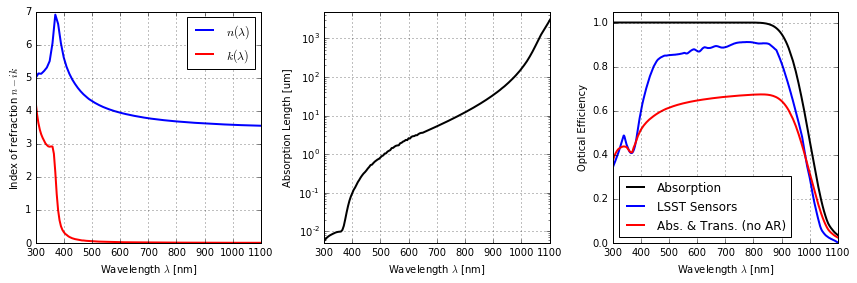

In [7]:
def load_silicon_optical_properties(save=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4), squeeze=True)
    
    index_table = astropy.table.Table.read('index.csv', format='ascii.csv', names=('wlen', 'n'))
    abs_table = astropy.table.Table.read('absorption.csv', format='ascii.csv', names=('wlen', 'k', 'a'))
    
    wlen = abs_table['wlen']
    k = abs_table['k']
    
    # Calculate the absorption length in microns.
    abs_len = 1e4 / abs_table['a']
    
    # Interpolate n onto the finer grid used for k.
    n = np.interp(wlen, index_table['wlen'], index_table['n'])
    
    # Calulate the Fresnel reflection coefficient at normal incidence.
    n0, k0 = 1., 0.
    R = ((n - n0) ** 2 + (k - k0) ** 2) / ((n + n0) ** 2 + (k + k0) ** 2)
    
    # Calculate the total probability of conversion in 100um.
    L0 = 100.
    prob = 1. - np.exp(-L0 / abs_len)
    
    ax[0].plot(wlen, n, 'b-', lw=2, label='$n(\lambda)$')
    ax[0].plot(wlen, k, 'r-', lw=2, label='$k(\lambda)$')
    
    ax[0].set_xlabel('Wavelength $\lambda$ [nm]')
    ax[0].set_ylabel('Index of refraction $n - i k$')
    ax[0].grid()
    ax[0].legend(loc='upper right')
    ax[0].set_xlim(300., 1100.)

    ax[1].plot(wlen, abs_len, 'k-', lw=2, label='$\alpha(\lambda)$')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Wavelength $\lambda$ [nm]')
    ax[1].set_ylabel('Absorption Length [um]')
    ax[1].set_xlim(300., 1100.)
    ax[1].set_ylim(0.005, 5e3)
    ax[1].grid()
    
    ax[2].plot(wlen, prob, 'k-', lw=2, label='Absorption')
    ax[2].plot(lsst['wlen'], lsst['det'], 'b-', lw=2, label='LSST Sensors')
    ax[2].plot(wlen, (1 - R) * prob, 'r-', lw=2, label='Abs. & Trans. (no AR)')
    ax[2].set_xlabel('Wavelength $\lambda$ [nm]')
    ax[2].set_ylabel('Optical Efficiency')
    ax[2].grid()
    ax[2].legend(loc='lower left')
    ax[2].set_xlim(300., 1100.)
    ax[2].set_ylim(0., 1.05)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
    # Return a linear interpolator of absorption length [um] vs wavelength [nm].
    return scipy.interpolate.interp1d(wlen, abs_len, copy=True, kind='linear')

abs_len = load_silicon_optical_properties()

## Source Models

Use the LSST simulation library of SEDs from [here](https://lsst-web.ncsa.illinois.edu/sim-data/sed_library/seds_160126.tar.gz), described [here](https://confluence.lsstcorp.org/display/SIM/SED+%28Spectral+Energy+Density%29+models+in+the+Catalogs+Simulation+Framework).  File is large (~826Mb) and can be installed for use here using:
```
mkdir SED
cd SED
curl -O "https://lsst-web.ncsa.illinois.edu/sim-data/sed_library/seds_160126.tar.gz"
tar -zxf seds_160126.tar.gz
rm seds_160126.tar.gz
export LSST_SED=$PWD
```
If `$LSST_SED` is not already defined in the environment you launched this notebook from, you can also add the path to the environment like this (uncomment and edit the following line):

In [8]:
#os.environ['LSST_SED']='...'

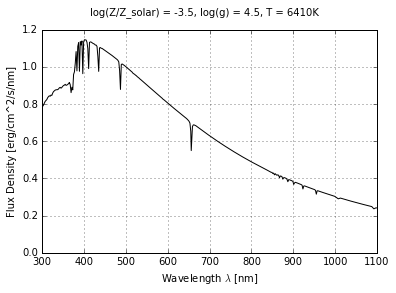

In [9]:
def get_stellar_sed(name = 'km35_6250.fits_g45_6410.gz', save=None):
    
    path = os.path.join(os.environ['LSST_SED'], 'starSED', 'kurucz', name)
    # Columns are Wavelength(nm) Flambda(ergs/cm^s/s/nm)
    sed = astropy.table.Table.read(path, format='ascii', names=('wlen', 'flambda'))
    
    plt.plot(sed['wlen'], sed['flambda'], 'k-')
    plt.xlim(300, 1100)
    plt.xlabel('Wavelength $\lambda$ [nm]')
    plt.ylabel('Flux Density [erg/cm^2/s/nm]')
    plt.grid()
    plt.suptitle('log(Z/Z_solar) = -3.5, log(g) = 4.5, T = 6410K')
    
    return sed

sed = get_stellar_sed()

## Absorption Profiles

Plot the relative probability density distribution of absorption depth and different fixed wavelengths:

u 367.070 nm  0.012 um 99.988
g 482.685 nm  0.660 um 99.340
r 622.324 nm  3.007 um 96.993
i 754.598 nm  8.145 um 91.855
z 869.090 nm 22.349 um 77.651
y 971.028 nm 41.253 um 58.747


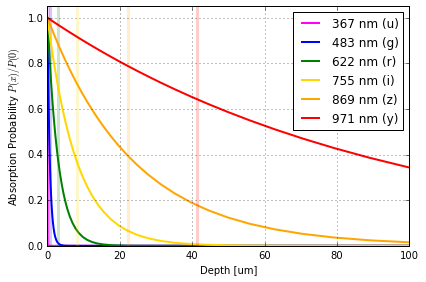

In [10]:
def plot_absorb_pdf(lsst, bands='ugrizy', save=None):
    x = np.logspace(-3., 2., 100)
    L = x[-1]
    dx = np.gradient(x)
    for i, band in enumerate(bands):
        eff_wlen = np.sum(lsst['wlen'] * lsst[band]) / np.sum(lsst[band])
        x0 = abs_len(eff_wlen)
        pdf = np.exp(-x / x0)
        plt.plot(x, pdf, color=band_color[band], lw=2, label='{0:.0f} nm ({1})'.format(eff_wlen, band))
        eff_depth = (x0 - np.exp(-L / x0) * (L + x0)) / (1. - np.exp(-L / x0))
        print '{0} {1:.3f} nm {2:6.3f} um {3:6.3f}'.format(band, eff_wlen, eff_depth, 100. - eff_depth)
        plt.axvline(eff_depth, lw=3, alpha=0.2, color=band_color[band])
    plt.ylim(0., 1.05)
    plt.legend(loc='upper right')
    plt.xlabel('Depth [um]')
    plt.ylabel('Absorption Probability $P(x)/P(0)$')
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

plot_absorb_pdf(lsst)

The depth PDF for a source with SED $s(\lambda)$ observed through a filter with total response $f(\lambda)$ is:
$$
p(x) = \int d\lambda\, s(\lambda) f(\lambda) \frac{e^{-x/a(\lambda)}}{1 - e^{-L/a(\lambda)}} \; ,
$$
where $L = 100$ um is the sensor thickness and the normalization of the last factor cancels out the absorption contribution to the throughput, and is necessary to avoid double counting.

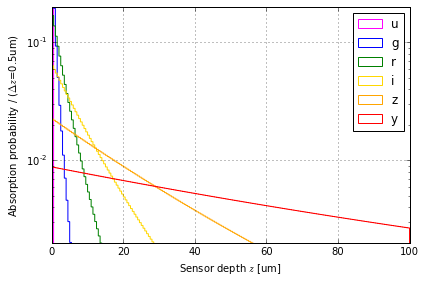

In [11]:
def calculate_depth_pdf(sed, lsst, abs_len, L=100., nx=200, ncdf=5000, save=None, write=False):
    
    # Initialize the table of results.
    out = astropy.table.Table()
    cdf = (np.arange(ncdf) + 0.5) / ncdf
    
    # Create a grid of depths into the sensor.
    x_edges = np.linspace(0., L, nx + 1)
    x_centers = 0.5 * (x_edges[1:] + x_edges[:-1])

    # Use the SED wavelength grid for integration, trimmed to 300-1100 nm.
    wlen = sed['wlen']
    i1 = np.where(wlen >= 300.)[0][0]
    i2 = np.where(wlen > 1100.)[0][0]
    wlen = wlen[i1:i2]
    flux = sed['flambda'][i1:i2]
    
    # Tabulate the absorption factor at each wavelength and position.
    # Integrate over each bin in x since the exponential can vary significantly
    # over a bin for bluer wavelengths.
    alen = abs_len(wlen)
    abs_fac = (np.exp(-x_edges[:-1, np.newaxis] / alen) -
               np.exp(-x_edges[1:, np.newaxis] / alen)) / (1 - np.exp(-L / alen))
    
    for band in 'ugrizy':
        # Interpolate the total throughput onto the SED wavelength grid.
        thru = np.interp(wlen, lsst['wlen'], lsst[band])
        # Integrate.
        result = scipy.integrate.trapz(flux * thru * abs_fac, wlen, axis=1)
        result /= np.sum(result)
        plt.hist(x=x_centers, bins=x_edges, weights=result, label=band,
                 color=band_color[band], histtype='step')
        # Convert the result into a more convenient format for random sampling in C.
        out[band] = np.interp(cdf, np.cumsum(result), x_centers)
    
    plt.yscale('log')
    plt.xlabel('Sensor depth $z$ [um]')
    plt.ylabel('Absorption probability / ($\Delta z$={0:.1f}um)'.format(L / nx))
    plt.ylim(2e-3, 0.2)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)
    if write:
        out.write('depth_pdf.dat', format='ascii')
    
calculate_depth_pdf(sed, lsst, abs_len)

## Random Sampling

The C pseudo-code for using the saved file to generate random depths in each band is:
```
// Initialize storage.
static const int n_bands = 6, n_depth_cdf = 5000;
double filter_cdf[n_bands, n_depth_cdf];

// Read contents of depth_pdf.dat into depth_cdf array.
// ...

// Generate one depth value in band FilterIndex (0-5).
int cdf_index = (int)floor(n_filter_cdf * drand48());
double depth = filter_cdf[cdf_index];
```
The code below tests this logic, which is now implemented as method `MultiGrid::GetElectronDepth()` in Craig's code.

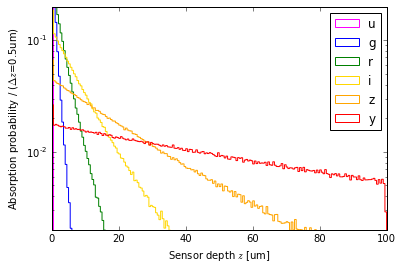

In [12]:
def test_sampling(n_sample=1000000, nx=200, L=100., seed=123):
    
    bands = 'ugrizy'
    n_band = len(bands)

    # Read the tabulated probabilities.
    pdf = astropy.table.Table.read('depth_pdf.dat', format='ascii', names=('u', 'g', 'r', 'i', 'z', 'y'))
    ncdf = len(pdf)
    x = np.empty((n_band, ncdf))
    for i, band in enumerate(bands):
        x[i] = pdf[band]

    # Generate uniform random numbers that represent CDF values.
    generator = np.random.RandomState(seed=seed)
    cdf = generator.uniform(size=(n_band, n_sample))
    
    # Convert each CDF value into a depth.
    cdf_bin = np.floor(ncdf * cdf).astype(int)
    for i, band in enumerate(bands):
        cdf_x = x[i, cdf_bin[i]]
        plt.hist(cdf_x, bins=nx, range=(0., L), histtype='step', normed='True',
                 color=band_color[band], label=band)
    plt.legend()
    plt.xlabel('Sensor depth $z$ [um]')
    plt.ylabel('Absorption probability / ($\Delta z$={0:.1f}um)'.format(L / nx))
    plt.yscale('log')
    plt.ylim(2e-3, 0.2)

test_sampling()